In [1]:
import os
import torch

from src.utils import AttrDict
from src.data.dictionary import Dictionary, BOS_WORD, EOS_WORD, PAD_WORD, UNK_WORD, MASK_WORD
from src.model.transformer import TransformerModel

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
model_path = 'new_dumped/xlm_only_mix/1/best-valid_mix_mlm_ppl.pth'
reloaded = torch.load(model_path)
params = AttrDict(reloaded['params'])

In [4]:
dico = Dictionary(reloaded['dico_id2word'], reloaded['dico_word2id'], reloaded['dico_counts'])

In [5]:
params.n_words = len(dico)
params.bos_index = dico.index(BOS_WORD)
params.eos_index = dico.index(EOS_WORD)
params.pad_index = dico.index(PAD_WORD)
params.unk_index = dico.index(UNK_WORD)
params.mask_index = dico.index(MASK_WORD)

# build model / reload weights
model = TransformerModel(params, dico, True, True)
model.eval()
model.load_state_dict(reloaded['model'])

In [6]:
new_params = {
    'batch_size':32, 
    'data_path':'./tmp', 
    'debug_slurm':False, 
    'debug_train':False, 
    'dropout':0, 
    'dump_path':'./new_dumped/test', 
    'epoch_size':20000, 
    'exp_id':'002', 
    'exp_name':'FT_ALL_FE1', 
    'finetune_layers':'0:_1', 
    'group_by_size':False, 
    'max_batch_size':0, 
    'max_len':256, 
    'max_vocab':-1, 
    'min_count':0, 
    'model_path':'/home/nanda/XLM_modif/new_dumped/xlm_all_new_data/1/best-valid_mix_mlm_ppl.pth', 
    'n_epochs':11, 
    'optimizer_e':'adam,lr=0.0001', 
    'optimizer_p':'adam,lr=0.0001', 
    'tokens_per_batch':-1, 
    'transfer_tasks':'', 
    'weighted_training':False
}

In [7]:
from src.data.loader import get_language_embedding, load_mix_binarized, process_mix_binarized, set_dico_parameters

In [8]:
from src.data.dataset import Dataset

In [9]:
data = {'mix':{splt: {} for splt in ['train', 'valid', 'test']}}

In [10]:
data1 = load_mix_binarized("/home/nanda/XLM_modif/data/processed/mix_SA/train.mix.pth", params)
data['dico'] = data.get('dico', data1['dico'])

In [11]:
set_dico_parameters(params, data, data1['dico'])

In [12]:
data['mix']['test']['x'] = Dataset(data1['sentences'], data1['positions'],params)

In [13]:
from src.model.embedder import SentenceEmbedder
import copy
import time
import json
from collections import OrderedDict
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

In [14]:
from types import SimpleNamespace
new_params = SimpleNamespace(**new_params)

In [15]:
# embedder
_embedder = SentenceEmbedder.reload(new_params.model_path, params)
embedder = copy.deepcopy(_embedder)
embedder.cuda()

# projection layer
proj = nn.Sequential(*[
    nn.Dropout(params.dropout),
    nn.Linear(embedder.out_dim, 2)
]).cuda()

In [16]:
def get_iterator(splt, lang):
        """
        Get a monolingual data iterator.
        """
        return data[lang][splt]['x'].get_iterator(
            shuffle=(splt == 'train'),
            return_indices=True
        )

In [17]:
from src.utils import concat_batches, truncate, to_cuda

In [18]:
idxs = []  # sentence indices
prob = []  # probabilities
pred = []  # predicted values
gold = []  # real values
has_labels = False
embedder.eval()
proj.eval()

for batch in get_iterator('test', 'mix'):
    print('test')
    (x, lengths), idx = batch
    y = self.data['mix'][splt]['y'][idx] if has_labels else None
    print(len(x))

    # cuda
    x, y, lengths = to_cuda(x, y, lengths)

    # prediction
    vector = embedder.get_embeddings(x, lengths, positions=None, langs=None)
#     output = proj(vector)
#     p = output.data.max(1)[1]
#     idxs.append(idx)
#     prob.append(output.cpu().detach().numpy())
#     pred.append(p.cpu().numpy())

test
237
test
204
test
167
test
468


RuntimeError: CUDA out of memory. Tried to allocate 113.38 MiB (GPU 0; 10.92 GiB total capacity; 8.68 GiB already allocated; 101.50 MiB free; 1.40 GiB cached)

# Plotting

In [23]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# Importing sklearn and TSNE.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
#from sklearn.utils.extmath import _ravel
# Random state we define this random state to use this value in TSNE which is a randmized algo.
RS = 25111993

# Importing matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# Importing seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

/home/nanda/anaconda3/envs/nanda_gpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [24]:
digits_proj = TSNE(random_state=1, init='pca').fit_transform(vector.cpu().detach().numpy())

In [25]:
digits_proj

array([[ 19.679932  ,   1.5204765 ],
       [ 36.80516   , -36.58079   ],
       [-21.47116   ,  19.25931   ],
       [  2.5717707 , -35.639404  ],
       [ 35.502106  ,  -0.19366784],
       [  2.8810503 ,  43.682228  ],
       [ -4.2577124 ,  25.023363  ],
       [  2.2174666 , -19.364511  ],
       [-10.557292  ,  -9.012825  ],
       [ 13.6854725 ,  28.880669  ],
       [-19.388493  ,  37.621037  ],
       [ 26.335608  ,  16.498703  ],
       [-42.39227   ,  -7.590197  ],
       [ 32.226204  , -17.175636  ],
       [ 53.19755   ,   0.08924009],
       [-24.409758  ,   1.710125  ],
       [-12.858208  , -26.962149  ],
       [-25.686861  , -15.659297  ],
       [-18.708624  , -43.828213  ],
       [-39.416172  ,  14.423859  ],
       [ 49.761803  , -20.331964  ],
       [ -8.135202  ,   7.819233  ],
       [  8.030906  ,  12.929135  ],
       [ 16.68164   , -13.640077  ],
       [ -0.34322232, -53.0608    ],
       [ 18.78772   , -29.811623  ],
       [ 20.00778   , -48.23878   ],
 

In [26]:
import numpy as np

In [27]:
# digits_proj0 = np.array([[ -59.59653  ,  -74.22992  ],
#        [   1.9410789,  336.6573   ],
#        [-214.63725  , -263.55646  ],
#        [ 228.18854  ,  292.6901   ],
#        [-227.2615   ,  360.9193   ],
#        [-383.24823  ,  164.96074  ],
#        [  33.05518  , -300.68826  ],
#        [-140.76265  ,  132.0442   ],
#        [-308.1269   ,  -52.912518 ],
#        [  78.43974  ,   99.1912   ],
#        [ 184.26881  , -126.74147  ],
#        [ 319.8902   ,   59.610996 ]])

In [28]:
ll=['ms','en','zh','mix','ms1','en1','zh1','mix1', 'ms2','en2','zh2','mix2' ]

In [29]:
digits_proj1 = np.array([[  84.87433 , -222.28302 ],
       [  48.70775 ,  -29.910389],
       [-109.24036 , -155.97322 ],
       [ 130.23973 , -119.769966],
       [ -20.836103,   69.51782 ],
       [-175.32176 ,  -65.41235 ],
       [ -35.586864, -240.4903  ],
       [   9.355569, -130.28902 ],
       [-130.85704 ,   48.013638],
       [  90.62738 ,   81.48389 ],
       [ -57.898396,  -46.024002],
       [ 166.62447 ,  -13.734828]])

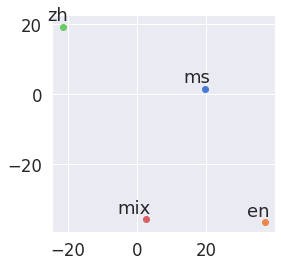

In [30]:
x = []
y = []
for value in digits_proj[0:4]:
    x.append(value[0])
    y.append(value[1])


plt.figure(figsize=(4, 4)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(ll[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

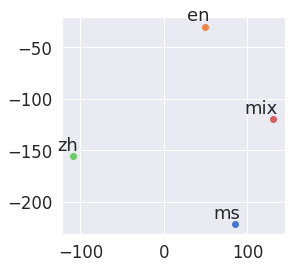

In [31]:
x = []
y = []
for value in digits_proj1[0:4]:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(4, 4)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(ll[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()